In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_mutual_info_score as ami, silhouette_score as sil_score, silhouette_samples as sil_samples
from sklearn.mixture import GaussianMixture
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from itertools import product
from helpers import cluster_acc
from sklearn.neural_network import MLPClassifier
from time import clock

**Load Spam**

In [12]:
spam_df = pd.read_csv('spambase.csv', header=0)
spam_x = spam_df.drop('class', axis=1).copy().values
spam_y = spam_df['class'].copy().values
spam_x = StandardScaler().fit_transform(spam_x)
spam_x.shape

(4601, 57)

**Load Digits**

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()
digits_x = StandardScaler().fit_transform(digits.data)
digits_y = digits.target
digits_x.shape

(1797, 64)

In [3]:
dims = [2,5,10,15,20,25,30,35,40,45,50,55]

In [6]:
from sklearn.metrics.pairwise import pairwise_distances
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

In [7]:
import scipy.sparse as sps
from scipy.linalg import pinv
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

In [8]:
spamTmpCorr = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    spamTmpCorr[dim][i] = pairwiseDistCorr(rp.fit_transform(spam_x), spam_x)
spamTmpCorr =pd.DataFrame(spamTmpCorr).T

In [9]:
spamTmpRec = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    rp.fit(spam_x)
    spamTmpRec[dim][i] = reconstructionError(rp, spam_x)
spamTmpRec =pd.DataFrame(spamTmpRec).T

In [10]:
digitsTmpCorr = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    digitsTmpCorr[dim][i] = pairwiseDistCorr(rp.fit_transform(digits_x), digits_x)
digitsTmpCorr =pd.DataFrame(digitsTmpCorr).T

In [11]:
digitsTmpRec = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    rp.fit(digits_x)
    digitsTmpRec[dim][i] = reconstructionError(rp, digits_x)
digitsTmpRec =pd.DataFrame(digitsTmpRec).T

In [4]:
def plot(df, title):
    x_points = df.index.values
    y_points = np.mean(df.iloc[:, 1:-1], axis=1)
    y_std = np.std(df.iloc[:, 1:-1], axis=1)
    plt.plot(x_points, y_points)
    plt.title(title)
    plt.show()

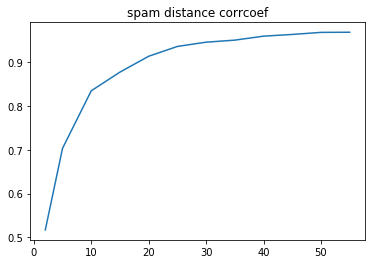

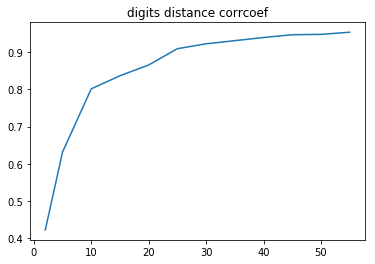

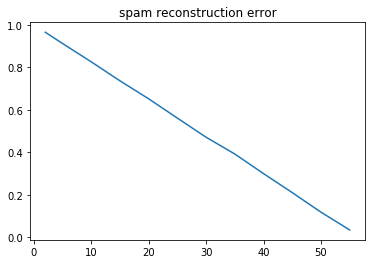

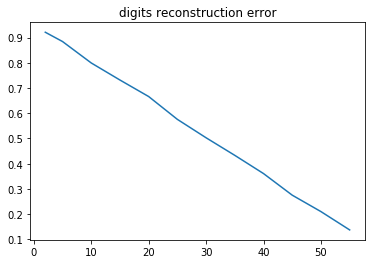

In [13]:
plot(spamTmpCorr, 'spam distance corrcoef')
plot(digitsTmpCorr, 'digits distance corrcoef')
plot(spamTmpRec, 'spam reconstruction error')
plot(digitsTmpRec, 'digits reconstruction error')

In [16]:
spam_rp = SparseRandomProjection(random_state=5, n_components=10)
spam_x_red = spam_rp.fit_transform(spam_x)
digits_rp = SparseRandomProjection(random_state=5, n_components=10)
digits_x_red = spam_rp.fit_transform(digits_x)
km = KMeans(random_state=5)
gmm = GaussianMixture(random_state=5)
clusters =  [2,5,10,15,20,25,30,35,40,50,70,80,90,100,115,130]
accSpam = {}
acc = defaultdict(lambda: defaultdict(dict))
SSE = defaultdict(dict)
ll = defaultdict(dict)
for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(digits_x_red)
    gmm.fit(digits_x_red)
    acc[k]['digits']['kmeans'] = cluster_acc(digits_y, km.predict(digits_x_red))
    acc[k]['digits']['gmm'] = cluster_acc(digits_y, gmm.predict(digits_x_red))
    SSE[k]['digits'] = km.score(digits_x_red)
    ll[k]['digits'] = gmm.score(digits_x_red)
    km.fit(spam_x_red)
    gmm.fit(spam_x_red)
    acc[k]['spam']['kmeans'] = cluster_acc(spam_y, km.predict(spam_x_red))
    acc[k]['spam']['gmm'] = cluster_acc(spam_y, gmm.predict(spam_x_red))
    SSE[k]['spam'] = km.score(spam_x_red)
    ll[k]['spam'] = gmm.score(spam_x_red)    

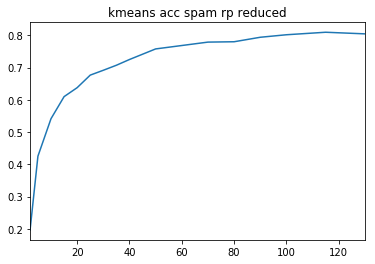

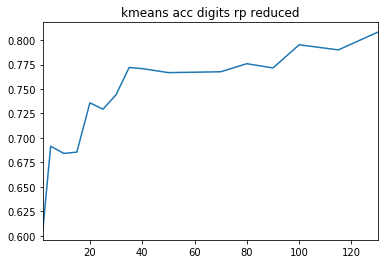

In [21]:
kmeansAccSpam = defaultdict(dict)
kmeansAccDigits = defaultdict(dict)
for k in acc:
    kmeansAccSpam[k] = acc[k]['digits']['kmeans']
    kmeansAccDigits[k] = acc[k]['spam']['kmeans']

pd.DataFrame.from_dict(kmeansAccSpam, orient='index', columns=['acc']).plot(title='kmeans acc spam rp reduced', legend=False)
pd.DataFrame.from_dict(kmeansAccDigits, orient='index', columns=['acc']).plot(title='kmeans acc digits rp reduced', legend=False)

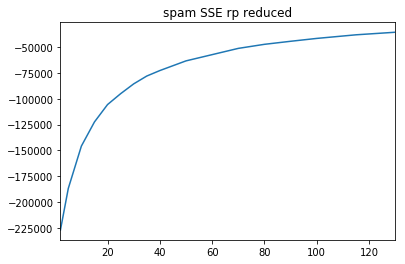

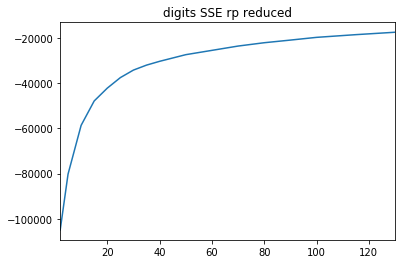

In [22]:
pd.DataFrame.from_dict(SSE, orient='index')['spam'].plot(title='spam SSE rp reduced')
plt.show()
pd.DataFrame.from_dict(SSE, orient='index')['digits'].plot(title='digits SSE rp reduced')

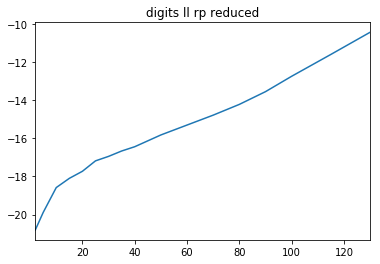

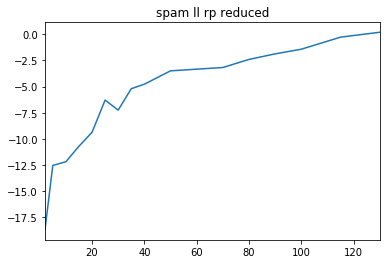

In [23]:
pd.DataFrame.from_dict(ll, orient='index')['digits'].plot(title='digits ll rp reduced')
plt.show()
pd.DataFrame.from_dict(ll, orient='index')['spam'].plot(title='spam ll rp reduced')

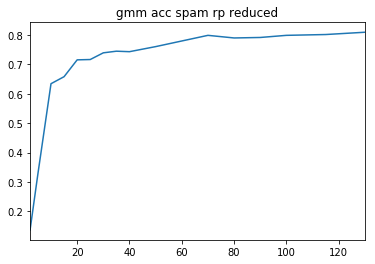

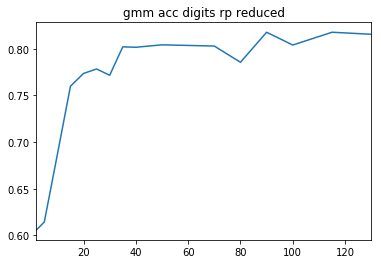

In [24]:
gmmAccSpam = defaultdict(dict)
gmmAccDigits = defaultdict(dict)
for k in acc:
    gmmAccSpam[k] = acc[k]['digits']['gmm']
    gmmAccDigits[k] = acc[k]['spam']['gmm']

pd.DataFrame.from_dict(gmmAccSpam, orient='index', columns=['acc']).plot(title='gmm acc spam rp reduced', legend=False)
pd.DataFrame.from_dict(gmmAccDigits, orient='index', columns=['acc']).plot(title='gmm acc digits rp reduced', legend=False)

In [6]:
dims = [2,5,10,15,20,25,30,35,40,45,50,55]
dims_times = defaultdict(dict)
dims_acc = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    spam_red = rp.fit_transform(spam_x)
    mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5, hidden_layer_sizes=(spam_red.shape[1], 57, 57))
    st = clock()
    mlp.fit(spam_red, spam_y)
    dims_times[dim][i] = clock() - st
    dims_acc[dim][i] = mlp.score(spam_red, spam_y)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/p

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


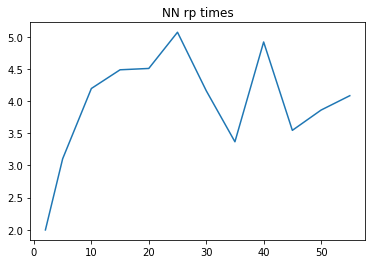

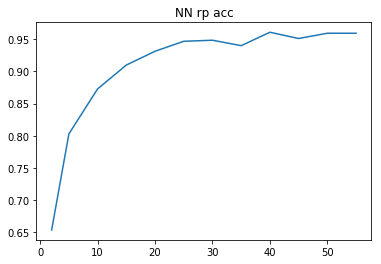

In [10]:
plot(pd.DataFrame(dims_times).T, 'NN rp times')
plot(pd.DataFrame(dims_acc).T, 'NN rp acc')